<span style="font-family: Arial; color: #000814; font-size: 24px; font-weight: bold;">Proyecto Final. Notebook No.3. Respuestas a 5 preguntas de negocio a partir de la Base de Datos.</span>

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">Se importan las librerías necesarias.</span>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import boto3
import psycopg2
import configparser

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">Nos identificamos en AWS.</span>

In [3]:
config = configparser.ConfigParser()
config.read('config.cfg')

['config.cfg']

In [4]:
RDS_HOST = 'tienda-transactional.cjykcg6gmirx.us-east-2.rds.amazonaws.com'
print(RDS_HOST)

tienda-transactional.cjykcg6gmirx.us-east-2.rds.amazonaws.com


In [5]:
postgres_driver = f"""postgresql://{config.get('TRANSACC', 'DB_USER')}:{config.get('TRANSACC', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('TRANSACC', 'DB_PORT')}/{config.get('TRANSACC', 'DB_NAME')}"""

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">Pregunta No.1 </span>

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">¿Cuáles son las categorías de artículo más vendidas?.</span>

In [6]:
data_Detalles_Venta = pd.read_csv('dimDetalleVenta.csv')
data_Detalles_Venta

,iddetalle_venta,cantidad,precio,descuento,tipo_comprobante,serie_comprobante,num_comprobante,fecha,impuesto,total,estado_venta,idcategoria,codigo,nombre,precio_venta,stock,descripcion,imagen,estado_articulo
0,4063241,11,780.50,720.97,Boleta de Venta,1174793,11785492,2015-04-28,15.11,80085.27,Pendiente,39582,AlUHoAdG,Suéter Himself,780.50,42,Artículo Suéter Himself en venta en tienda,fig_341,1
1,4818419,12,780.50,464.28,Nota de Crédito,1249982,13357780,2018-09-01,27.04,90554.74,Cancelada,39582,AlUHoAdG,Suéter Himself,780.50,42,Artículo Suéter Himself en venta en tienda,fig_341,1
2,9216433,31,780.50,701.73,Nota de Débito,8190903,64781244,2022-10-11,95.83,2694.43,Pendiente,39582,AlUHoAdG,Suéter Himself,780.50,42,Artículo Suéter Himself en venta en tienda,fig_341,1
3,5892399,2,780.50,752.25,Nota de Crédito,7266067,38946606,2022-07-19,4.99,4558.94,En proceso,39582,AlUHoAdG,Suéter Himself,780.50,42,Artículo Suéter Himself en venta en tienda,fig_341,1
4,6277097,39,780.50,671.87,Recibo,5897278,57441336,2020-11-30,98.70,30701.73,Pendiente,39582,AlUHoAdG,Suéter Himself,780.50,42,Artículo Suéter Himself en venta en tienda,fig_341,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7099948,9,542.15,587.19,Nota de Crédito,8550059,42831539,2021-04-12,83.30,36697.73,Pendiente,51470,XvRa4ZtZ,Juguete Other,542.15,42,Artículo Juguete Other en venta en tienda,fig_568,1
4996,7424797,26,542.15,922.12,Ticket de Venta,3029498,10052110,2019-12-05,9.78,22439.78,Pendiente,51470,XvRa4ZtZ,Juguete Other,542.15,42,Artículo Juguete Other en venta en tienda,fig_568,1
4997,7174943,89,542.15,803.44,Factura,6504422,94855155,2020-06-22,39.65,15748.99,Cancelada,51470,XvRa4ZtZ,Juguete Other,542.15,42,Artículo Juguete Other en venta en tienda,fig_568,1
4998,4764506,9,266.80,686.09,Boleta de Venta,5800930,11856858,2022-08-20,55.63,38395.18,En proceso,75369,9cpmp2g3,Portátil Career,266.80,52,Artículo Portátil Career en venta en tienda,fig_324,1


In [7]:
data_Detalles_Venta.columns

Index(['iddetalle_venta', 'cantidad', 'precio', 'descuento',
       'tipo_comprobante', 'serie_comprobante', 'num_comprobante', 'fecha',
       'impuesto', 'total', 'estado_venta', 'idcategoria', 'codigo', 'nombre',
       'precio_venta', 'stock', 'descripcion', 'imagen', 'estado_articulo'],
      dtype='object')

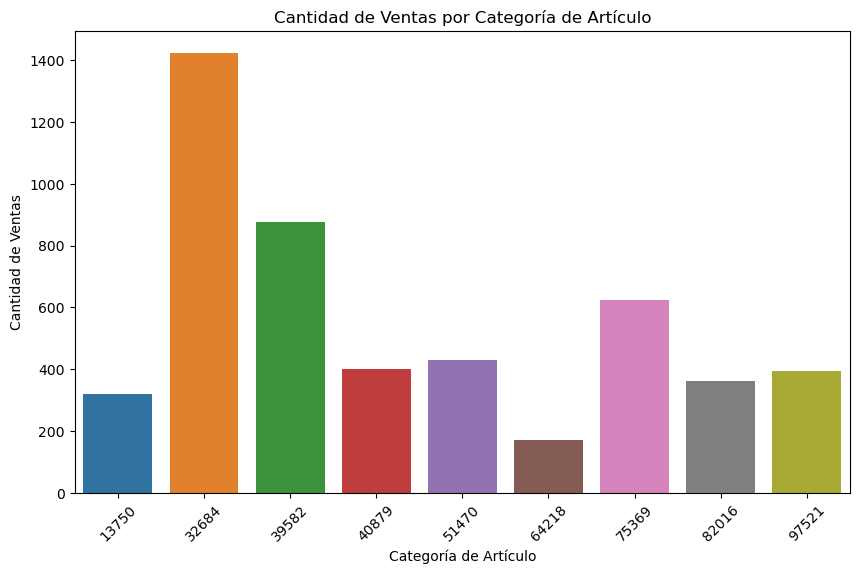

In [8]:
# Crear el gráfico usando Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data_Detalles_Venta, x='idcategoria')
plt.title('Cantidad de Ventas por Categoría de Artículo')
plt.xlabel('Categoría de Artículo')
plt.ylabel('Cantidad de Ventas')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">Pregunta No.2 </span>

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">¿Cómo varía el total de ventas entre estas categorías?.</span>

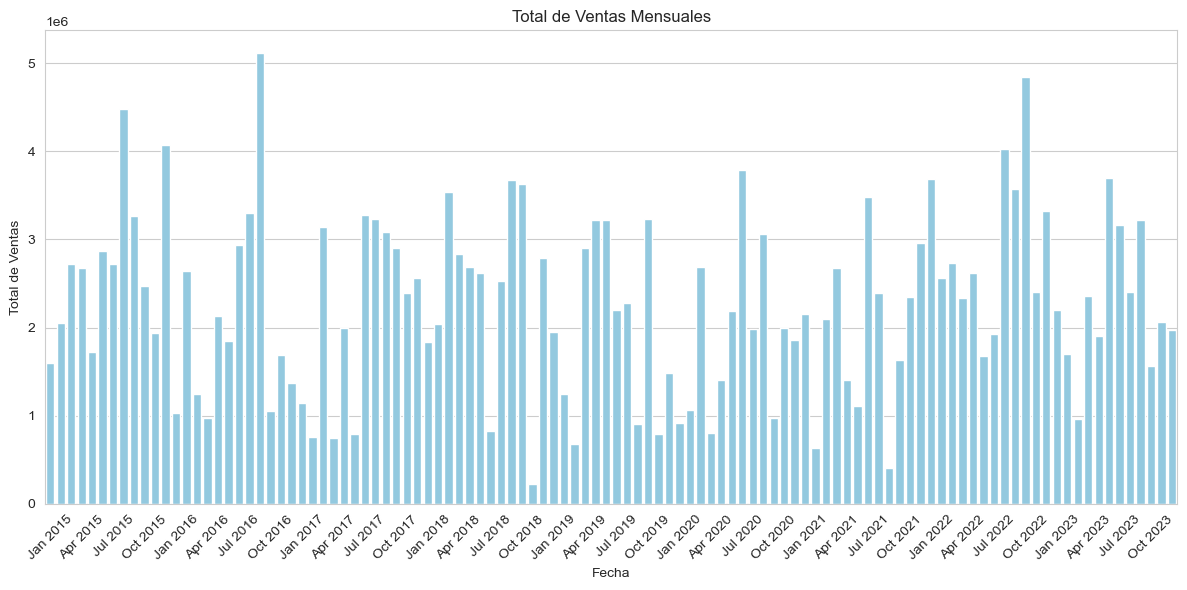

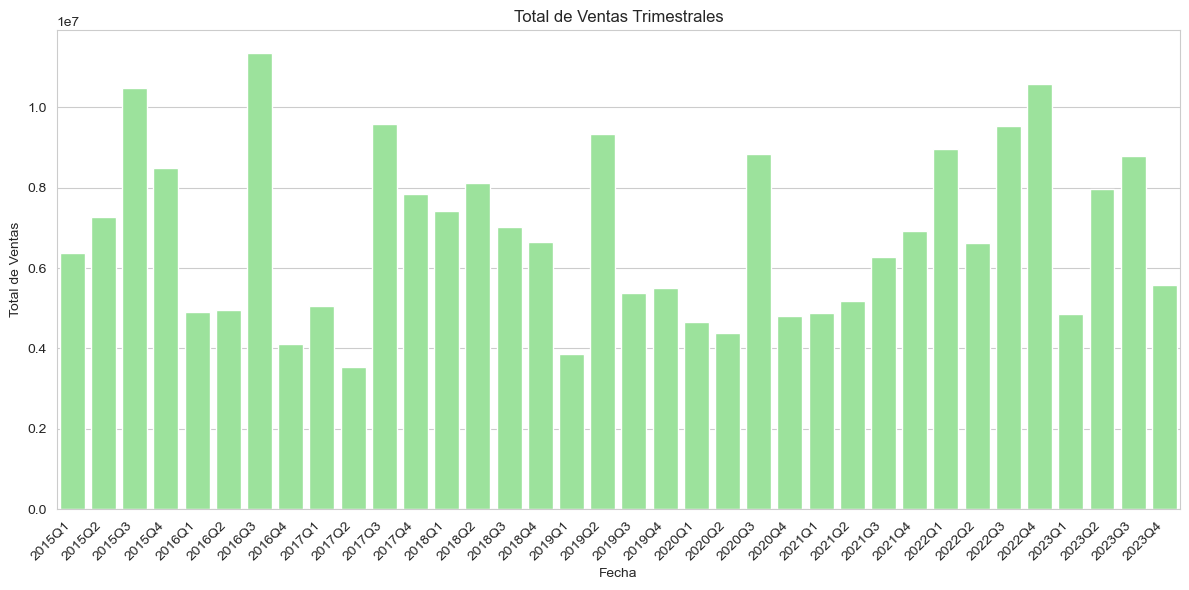

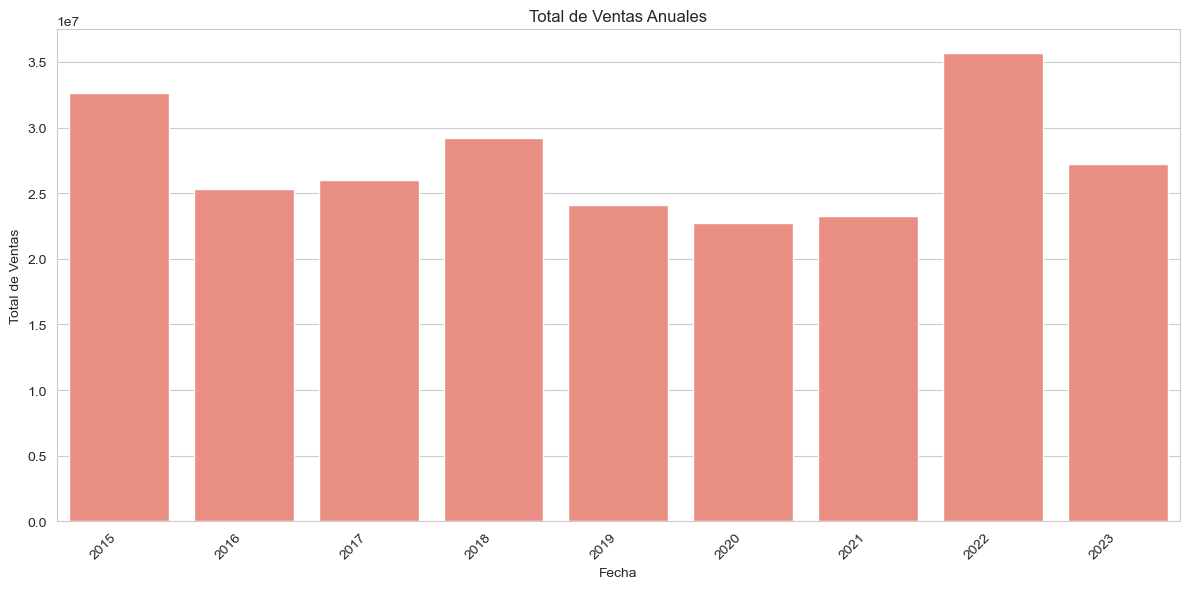

In [9]:
# Convertir la columna 'fecha' a tipo datetime
data_Detalles_Venta['fecha'] = pd.to_datetime(data_Detalles_Venta['fecha'])

# Agrupar las ventas por mes y sumar el total de ventas para cada mes
ventas_mensuales = data_Detalles_Venta.groupby(pd.Grouper(key='fecha', freq='M')).agg({'total': 'sum'}).reset_index()

# Agrupar las ventas por trimestre y sumar el total de ventas para cada trimestre
ventas_trimestrales = data_Detalles_Venta.groupby(pd.Grouper(key='fecha', freq='Q')).agg({'total': 'sum'}).reset_index()

# Agrupar las ventas por año y sumar el total de ventas para cada año
ventas_anuales = data_Detalles_Venta.groupby(pd.Grouper(key='fecha', freq='Y')).agg({'total': 'sum'}).reset_index()

# Configurar el estilo de los gráficos de Seaborn
sns.set_style("whitegrid")

# Crear un gráfico de barras agrupadas para las ventas mensuales

# Seleccionar solo cada tercer mes para los ticks del eje x
ticks_seleccionados = ventas_mensuales['fecha'][::3]

plt.figure(figsize=(12, 6))
sns.barplot(x=ventas_mensuales['fecha'].dt.strftime('%b %Y'), y=ventas_mensuales['total'], color='skyblue')
plt.title('Total de Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
# Establecer los ticks del eje x
plt.xticks(ticks=ticks_seleccionados.index, labels=ticks_seleccionados.dt.strftime('%b %Y'), rotation=45, ha='center')
plt.tight_layout()
plt.show()

# Crear un gráfico de barras agrupadas para las ventas trimestrales
plt.figure(figsize=(12, 6))
sns.barplot(x=ventas_trimestrales['fecha'].dt.to_period('Q').astype(str), y=ventas_trimestrales['total'], color='lightgreen')
plt.title('Total de Ventas Trimestrales')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Crear un gráfico de barras agrupadas para las ventas anuales
plt.figure(figsize=(12, 6))
sns.barplot(x=ventas_anuales['fecha'].dt.strftime('%Y'), y=ventas_anuales['total'], color='salmon')
plt.title('Total de Ventas Anuales')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">Pregunta No.3 </span> 

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">¿Qué rol o roles tienden a tener un mayor impacto en el resultado final de las ventas?.</span> 

In [10]:
sql_query = 'SELECT * FROM venta;'
df_venta = pd.read_sql(sql_query, postgres_driver)
df_venta = df_venta.rename(columns={'estado': 'estado_venta'})
df_venta.head()

,idventa,idcliente,idusuario,tipo_comprobante,serie_comprobante,num_comprobante,fecha,impuesto,total,estado_venta
0,636929,218807615,5192591,Recibo,1548290,77699072,2021-06-20,32.23,30445.21,Pendiente
1,802818,362426775,9231609,Factura,5533699,29886468,2015-09-24,72.82,9944.34,Pendiente
2,925698,199304738,3698332,Recibo,5277702,59021317,2019-06-24,66.60,26724.47,En proceso
3,466950,369537545,8967426,Nota de Débito,7122955,57681925,2015-12-24,84.97,26303.25,Completada
4,981001,201190852,4535468,Factura,5711883,98777097,2018-03-03,40.93,71179.31,Pendiente


In [11]:
sql_query = 'SELECT * FROM persona'
df_cliente = pd.read_sql(sql_query, postgres_driver)
df_cliente = df_cliente[df_cliente['tipo_persona']=='cliente']
df_cliente = df_cliente.rename(columns={'idpersona': 'idcliente', 'nombre': 'nombre_cliente', 'tipo_documento': 'tipo_documento_cliente', 'num_documento': 'num_documento_cliente','direccion': 'direccion_cliente', 'telefono': 'telefono_cliente', 'email': 'email_cliente'})
df_cliente.head()

,idcliente,tipo_persona,nombre_cliente,tipo_documento_cliente,num_documento_cliente,direccion_cliente,telefono_cliente,email_cliente
1,194772995,cliente,Jeremy Sanchez,Pasaporte,177566692218882,USNV Reed FPO AE 29082,662-949-,yrichardson@hotmail.com
2,821172229,cliente,Lauren Everett,NIE,122589503164419,"493 Shepherd Turnpike Suite 415 Harpershire, O...",672-397-,william21@gmail.com
3,754774022,cliente,Dan Hernandez,DNI,182064191703046,"527 Diane Locks Suite 818 Emilyfurt, VA 16746",310.228.,rmoody@yahoo.com
5,435355658,cliente,Christopher Phillips,Pasaporte,165991424086024,"005 Angela Springs Apt. 354 South Angela, ME 5...",277.868.,betty38@yahoo.com
6,664700941,cliente,Ashley Morgan MD,NIE,194934328872971,USS Benson FPO AA 80744,+1-228-7,scott93@gmail.com


In [12]:
df_venta_cliente = df_venta.merge(df_cliente, how='inner', on='idcliente')
df_venta_cliente.head()

,idventa,idcliente,idusuario,tipo_comprobante,serie_comprobante,num_comprobante,fecha,impuesto,total,estado_venta,tipo_persona,nombre_cliente,tipo_documento_cliente,num_documento_cliente,direccion_cliente,telefono_cliente,email_cliente
0,925698,199304738,3698332,Recibo,5277702,59021317,2019-06-24,66.60,26724.47,En proceso,cliente,Samantha Olsen,DNI,139925835644452,"07010 Tara Mount Tannertown, WA 98985",+1-310-5,luke15@gmail.com
1,981001,201190852,4535468,Factura,5711883,98777097,2018-03-03,40.93,71179.31,Pendiente,cliente,Theresa Gaines,NIE,179154902717881,"6320 Barbara Dam Suite 624 North Manueltown, S...",707-585-,mcox@hotmail.com
2,494960,201190852,3112378,Boleta de Venta,6681938,31137142,2017-12-13,39.04,3634.40,Completada,cliente,Theresa Gaines,NIE,179154902717881,"6320 Barbara Dam Suite 624 North Manueltown, S...",707-585-,mcox@hotmail.com
3,177650,201190852,6406880,Boleta de Venta,8619470,69189073,2021-12-03,0.12,51240.41,Pendiente,cliente,Theresa Gaines,NIE,179154902717881,"6320 Barbara Dam Suite 624 North Manueltown, S...",707-585-,mcox@hotmail.com
4,358413,118805658,4326702,Recibo,4642828,60155916,2016-11-09,16.61,20499.82,Completada,cliente,Brittany Alexander,Tarjeta Residencia,143515372700787,"69618 Ruiz Shoals Nancyshire, VA 04563",+1-277-9,justin42@yahoo.com


In [13]:
sql_query = 'SELECT * FROM usuario;'
df_usuario = pd.read_sql(sql_query, postgres_driver)
df_usuario = df_usuario.rename(columns={'nombre': 'nombre_usuario', 'tipo_documento': 'tipo_documento_usuario', 'num_documento': 'num_documento_usuario','direccion': 'direccion_usuario', 'telefono': 'telefono_usuario', 'email': 'email_usuario', 'estado': 'estado_cliente'})
df_usuario.head()

,idusuario,idrol,nombre_usuario,tipo_documento_usuario,num_documento_usuario,direccion_usuario,telefono_usuario,email_usuario,clave,estado_cliente
0,8519681,10003,Joseph Simmons,DNI,160270278742016,"798 Flores Inlet South Richard, KS 94909",(976)205,youngryan@hotmail.com,"[b'7', b'3', b'a', b'7', b'8', b'3', b'3', b'd...",0
1,4730883,10005,Amber Harrison,Pasaporte,105054972573702,"7227 Johnson Forest North Jonathonport, NM 59493",(819)887,rachelmills@yahoo.com,"[b'c', b'b', b'b', b'2', b'4', b'b', b'1', b'2...",0
2,1126405,10002,Keith Williams,DNI,129550405193737,"41637 Sawyer Track Apt. 125 Wallacemouth, TX 9...",450-411-,bradleymitchell@yahoo.com,"[b'7', b'b', b'7', b'5', b'f', b'1', b'5', b'8...",0
3,7086086,10001,Keith Moore,DNI,168650743121940,"53973 Smith Plaza New Jeffrey, CA 04929",(724)685,nielsenmichelle@hotmail.com,"[b'c', b'c', b'3', b'a', b'9', b'9', b'8', b'4...",1
4,7884808,10002,Natalie Mercer,NIE,187447326345237,"PSC 7255, Box 9372 APO AA 79137",+1-266-5,ruth56@yahoo.com,"[b'a', b'7', b'c', b'd', b'e', b'1', b'b', b'2...",1


In [14]:
df_venta_cliente_usuario = df_venta_cliente.merge(df_usuario, how='inner', on='idusuario')
df_venta_cliente_usuario = df_venta_cliente_usuario.drop(['idcliente'], axis=1)
df_venta_cliente_usuario.head()

,idventa,idusuario,tipo_comprobante,serie_comprobante,num_comprobante,fecha,impuesto,total,estado_venta,tipo_persona,...,email_cliente,idrol,nombre_usuario,tipo_documento_usuario,num_documento_usuario,direccion_usuario,telefono_usuario,email_usuario,clave,estado_cliente
0,925698,3698332,Recibo,5277702,59021317,2019-06-24,66.60,26724.47,En proceso,cliente,...,luke15@gmail.com,10002,Laura Norman,Pasaporte,137041096498865,"8629 Rita Overpass Suite 903 Travisside, NC 98041",897-364-,brandon45@yahoo.com,"[b'f', b'a', b'2', b'e', b'1', b'd', b'2', b'6...",0
1,981001,4535468,Factura,5711883,98777097,2018-03-03,40.93,71179.31,Pendiente,cliente,...,mcox@hotmail.com,10002,Danielle Mills,DNI,164406115294418,"380 Stafford Rest Suite 084 Lake Chadshire, VT...",544.230.,george58@yahoo.com,"[b'1', b'b', b'5', b'3', b'5', b'1', b'e', b'2...",0
2,494960,3112378,Boleta de Venta,6681938,31137142,2017-12-13,39.04,3634.40,Completada,cliente,...,mcox@hotmail.com,10003,Gary Brown,DNI,149856481973744,"8115 Morris Ranch Hartmanfort, PA 40963",956.242.,markslaura@gmail.com,"[b'f', b'a', b'e', b'7', b'a', b'5', b'6', b'e...",0
3,183799,3112378,Recibo,3036624,37961174,2017-05-22,45.31,47151.04,Cancelada,cliente,...,moorekelly@gmail.com,10003,Gary Brown,DNI,149856481973744,"8115 Morris Ranch Hartmanfort, PA 40963",956.242.,markslaura@gmail.com,"[b'f', b'a', b'e', b'7', b'a', b'5', b'6', b'e...",0
4,177650,6406880,Boleta de Venta,8619470,69189073,2021-12-03,0.12,51240.41,Pendiente,cliente,...,mcox@hotmail.com,10003,Rodney Hendricks,DNI,157594144404203,"76126 Lisa Points Suite 687 Michelleburgh, ME ...",(881)667,luiscontreras@gmail.com,"[b'e', b'a', b'a', b'a', b'4', b'1', b'e', b'b...",1


In [15]:
df_venta_cliente_usuario.columns

Index(['idventa', 'idusuario', 'tipo_comprobante', 'serie_comprobante',
       'num_comprobante', 'fecha', 'impuesto', 'total', 'estado_venta',
       'tipo_persona', 'nombre_cliente', 'tipo_documento_cliente',
       'num_documento_cliente', 'direccion_cliente', 'telefono_cliente',
       'email_cliente', 'idrol', 'nombre_usuario', 'tipo_documento_usuario',
       'num_documento_usuario', 'direccion_usuario', 'telefono_usuario',
       'email_usuario', 'clave', 'estado_cliente'],
      dtype='object')

In [16]:
data_roles = pd.read_csv('dimRol.csv')
data_roles.head()

,idrol,nombre,descripcion,estado
0,10001,Administrador,Este rol tiene acceso completo al sistema y pu...,1
1,10002,Moderador,Este rol tiene permisos para moderar contenido...,1
2,10003,Usuario Estándar,Este rol tiene acceso limitado y puede realiza...,1
3,10004,Soporte Técnico,Este rol proporciona soporte técnico y tiene a...,1
4,10005,Invitado,Este rol tiene acceso limitado y solo puede ve...,1


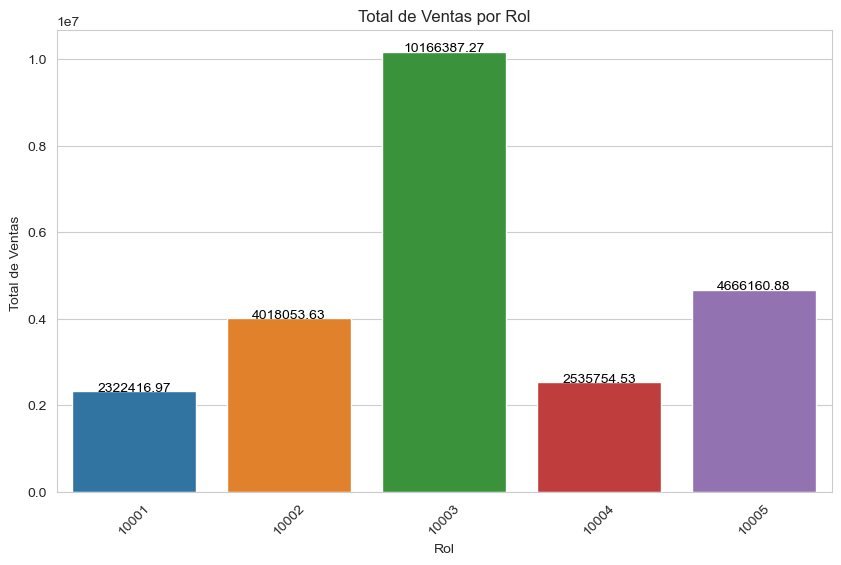

In [17]:
# Paso 1: Relacionar los datos de ventas con los datos de usuarios

# Paso 2: Relacionar los datos de usuarios con los roles
usuarios_roles = pd.merge(df_venta_cliente_usuario, data_roles, how='left', on='idrol')

# Paso 3: Calcular el total de ventas por rol
ventas_por_rol = usuarios_roles.groupby('idrol')['total'].sum().reset_index()

# Paso 4: Visualizar los resultados
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='idrol', y='total', data=ventas_por_rol.sort_values(by='total', ascending=False))
plt.xlabel('Rol')
plt.ylabel('Total de Ventas ')
plt.title('Total de Ventas por Rol')
plt.xticks(rotation=45)

# Agregar etiquetas de texto en las barras
for index, row in ventas_por_rol.iterrows():
    ax.text(index, row['total'], str(round(row['total'], 2)), color='black', ha="center")

plt.show()

 <span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">Pregunta No.4</span>
 
 <span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">¿Cómo varían las ventas en diferentes momentos del año, como durante las vacaciones o eventos especiales?.</span>

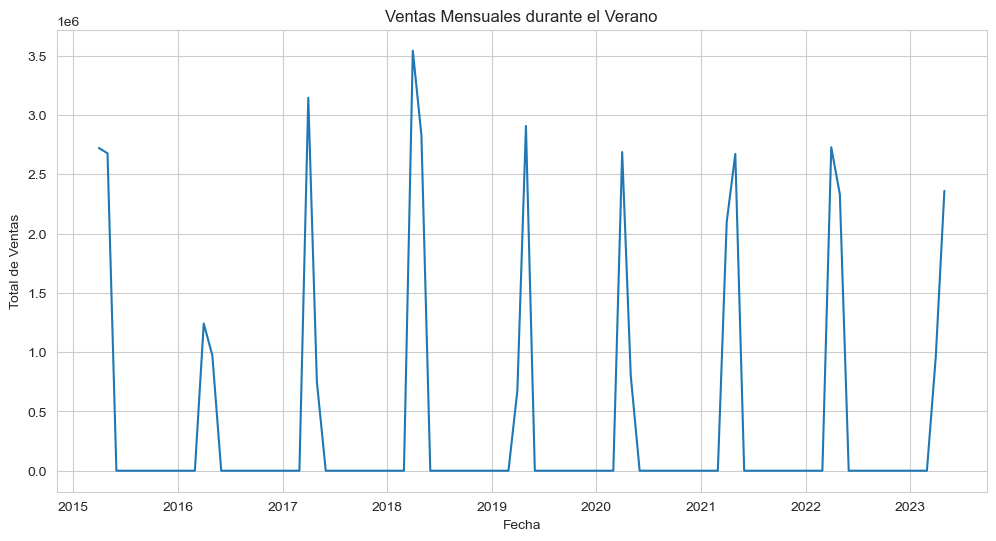

In [18]:
# Paso 1: Identificar los períodos de interés (por ejemplo, las ventas durante las vacaciones de verano)
ventas_verano = data_Detalles_Venta[(data_Detalles_Venta['fecha'].dt.month >= 3) & (data_Detalles_Venta['fecha'].dt.month <= 4)]

# Paso 2: Agrupar las ventas por mes y calcular el total de ventas para cada mes durante el verano
ventas_verano_mensuales = ventas_verano.groupby(pd.Grouper(key='fecha', freq='M')).agg({'total': 'sum'}).reset_index()

# Paso 3: Visualizar los datos
plt.figure(figsize=(12, 6))
sns.lineplot(x='fecha', y='total', data=ventas_verano_mensuales)
plt.title('Ventas Mensuales durante el Verano')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
plt.show()

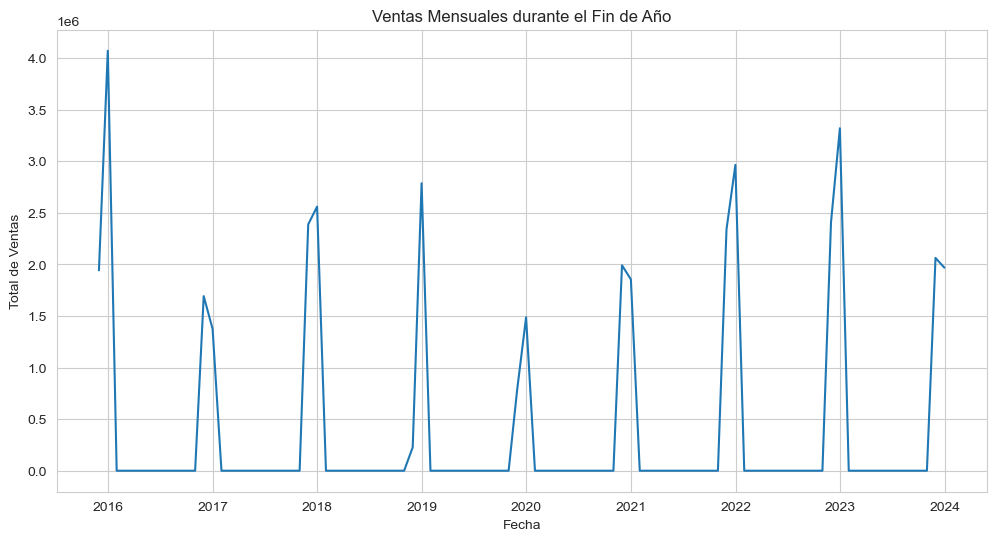

In [19]:
# Paso 1: Identificar los períodos de interés (las ventas durante las fiestas de fin de año)
ventas_fin_de_anio = data_Detalles_Venta[(data_Detalles_Venta['fecha'].dt.month >= 11) & (data_Detalles_Venta['fecha'].dt.month <= 12)]

# Paso 2: Agrupar las ventas por mes y calcular el total de ventas para cada mes durante el verano
ventas_fin_de_anio_mensuales = ventas_fin_de_anio.groupby(pd.Grouper(key='fecha', freq='M')).agg({'total': 'sum'}).reset_index()

# Paso 3: Visualizar los datos
plt.figure(figsize=(12, 6))
sns.lineplot(x='fecha', y='total', data=ventas_fin_de_anio_mensuales)
plt.title('Ventas Mensuales durante el Fin de Año')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
plt.show()

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">Pregunta No.5.</span> 

<span style="font-family: Arial; color: #0077b6; font-size: 18px; font-weight: bold;">¿Cómo se correlaciona el nivel de stock de los artículos con las ventas realizadas? ¿Existen artículos que constantemente tienen un bajo nivel de stock pero alta demanda?.</span> 

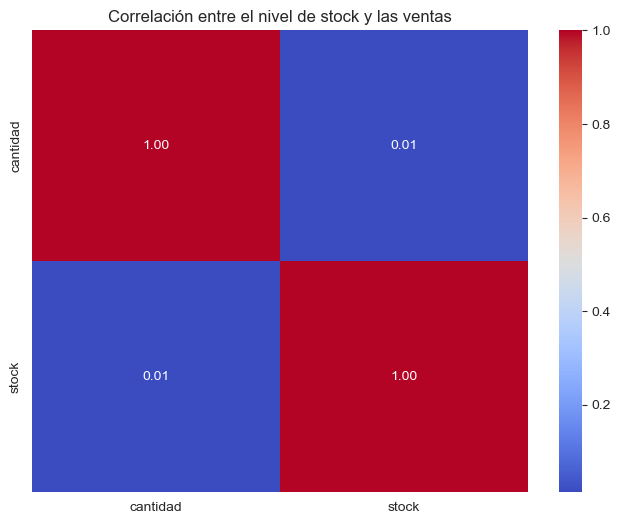

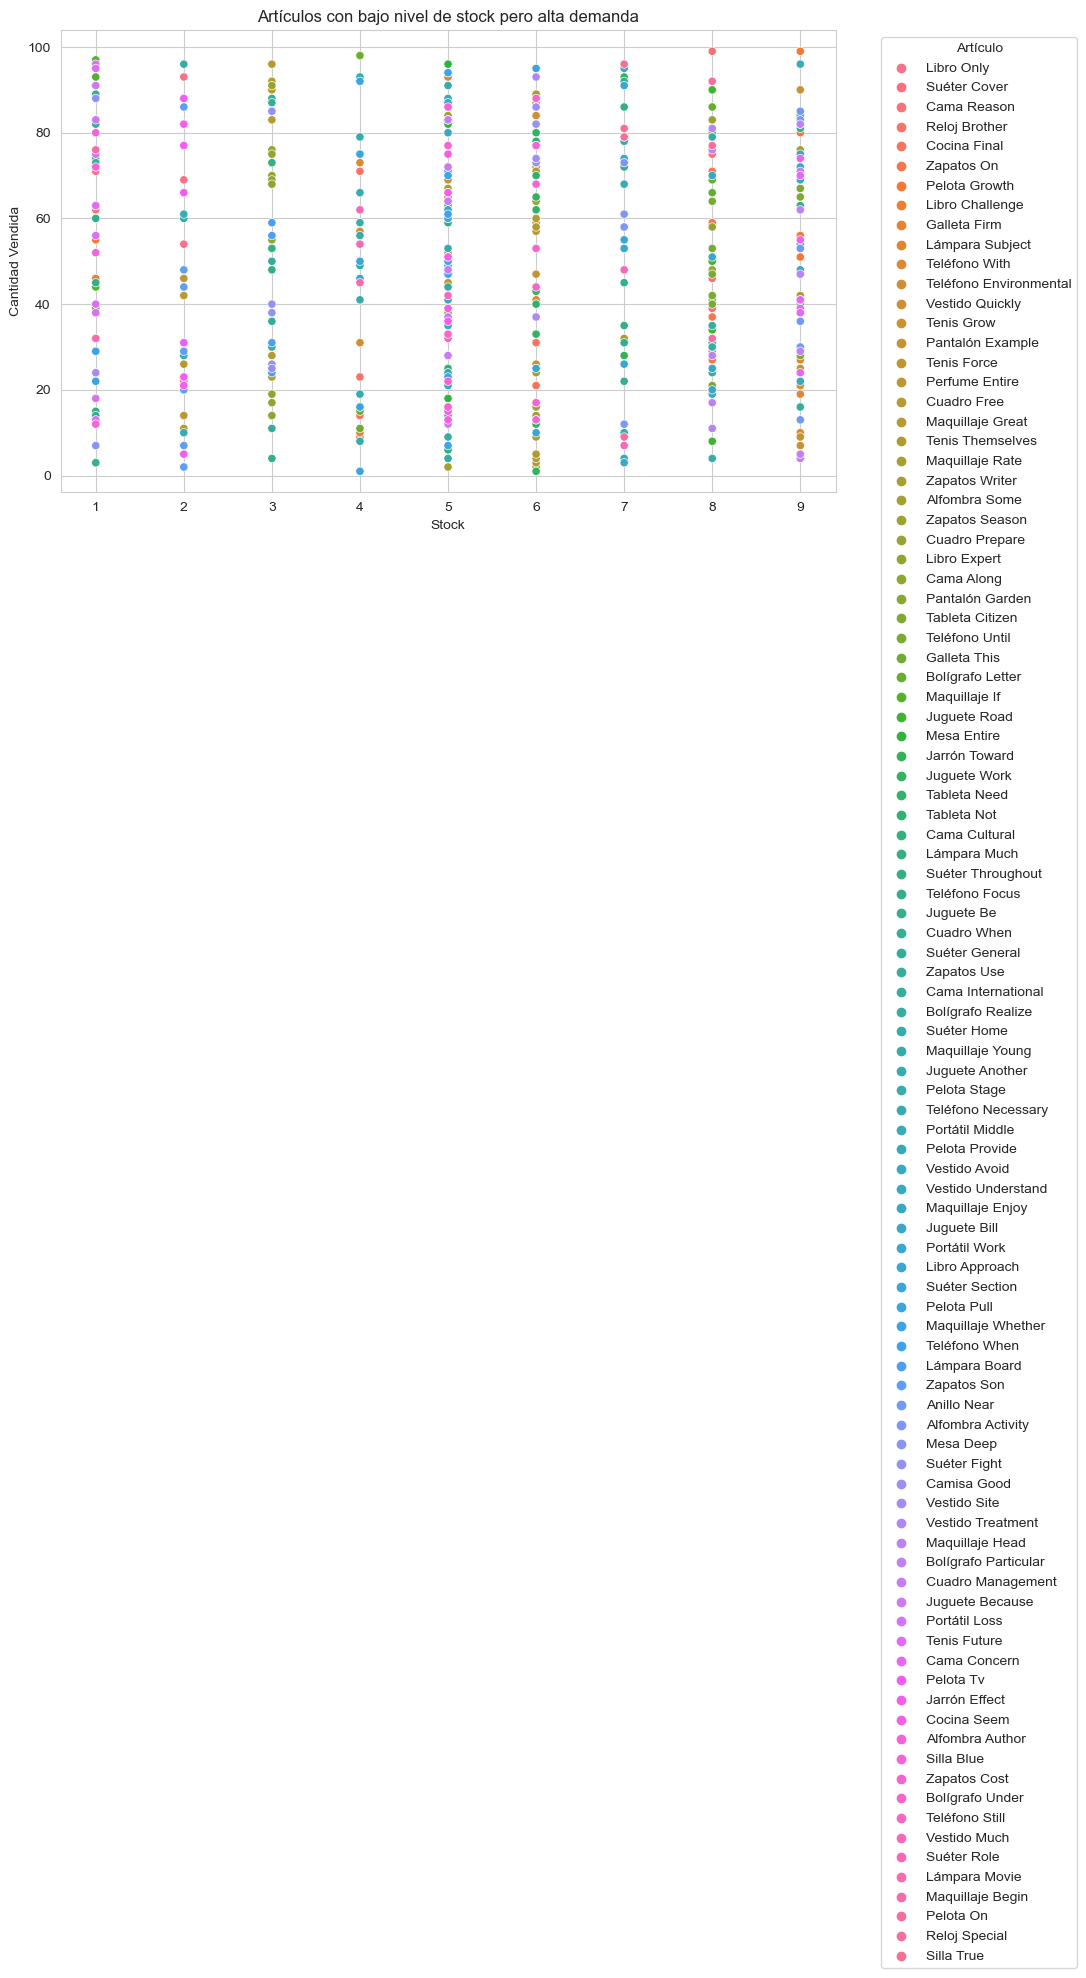

In [20]:
# Correlación entre el nivel de stock y las ventas
correlation = data_Detalles_Venta[['cantidad', 'stock']].corr()

# Identificar artículos con bajo nivel de stock pero alta demanda
# Filtrar los artículos con stock bajo
low_stock_items = data_Detalles_Venta[data_Detalles_Venta['stock'] < 10]  # Por ejemplo, artículos con menos de 10 unidades en stock

# Filtrar los artículos con alta demanda (por ejemplo, los más vendidos)
high_demand_items = data_Detalles_Venta[data_Detalles_Venta['cantidad'] > data_Detalles_Venta['cantidad'].mean()]  # Artículos que se vendieron más que el promedio

# Visualización de la correlación entre el nivel de stock y las ventas
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre el nivel de stock y las ventas')
plt.show()

# Visualización de los artículos con bajo nivel de stock pero alta demanda
plt.figure(figsize=(10, 6))
sns.scatterplot(data=low_stock_items, x='stock', y='cantidad', hue='nombre')
plt.title('Artículos con bajo nivel de stock pero alta demanda')
plt.xlabel('Stock')
plt.ylabel('Cantidad Vendida')
plt.legend(title='Artículo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()